<a href="https://colab.research.google.com/github/tonima15-2686/AI_ML_DIU_CSE_Spring2021/blob/main/Using_transfer_learning_technique_(inception_v3_and_mobilenet)_for_fruits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
from zipfile import ZipFile
import PIL

import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
dataset_url = "https://storage.googleapis.com/kaggle-data-sets/5857%2F1166105%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1599228654&Signature=BGqY%2BsLSb5lp2kyyDV5r859MClfo9qj0a5j056di3Pu26vyMmUKBQ4H%2BAGdeB%2FzhxQp2MsFChCxJbt0JzpYnV%2FBCNcQLpVuJuhh6dFnhuOW0DFhoW9AzsucGTv1hu2uYUBpjxu6pgnMuq4ERBSC6CsSQ8s4gCH9VKUjXj%2Fdq1tdZJPxL%2B3DaLocKswWgIyXm02OtdyYlSjAudIDQ4QEniLtWDhK10SKpMej4rR41%2F8dn%2BoxRrL668KXYSeIuI8aVxGpwswV%2BQW0xIk8hfGHwU4bJ8YO8iQA0TyVsx%2BcurL5%2BT6pJ0W96sqN4p804EcVHv4ByGrm7q%2F4wENkdbwbCZA%3D%3D"

In [4]:
data_dir = tf.keras.utils.get_file("/content/gdrive/MyDrive/fruits classification", origin=dataset_url)

In [ ]:
zf = ZipFile(data_dir)
zf.extractall("/content/gdrive/MyDrive/fruits classification/fruits-360")

In [7]:
train_dir = pathlib.Path("/content/gdrive/MyDrive/fruits classification/fruits-360/Training")
test_dir = pathlib.Path("/content/gdrive/MyDrive/fruits classification/fruits-360/Test")

In [8]:
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

7662

Visualization

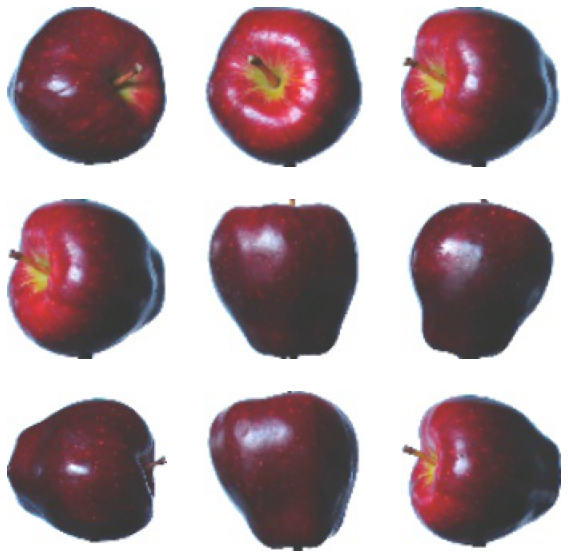

In [9]:
fruits = list(train_dir.glob('Apple Red Delicious/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [10]:
batch_size = 32
img_height = 100
img_width = 100

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7662 files belonging to 131 classes.
Using 6130 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7662 files belonging to 131 classes.
Using 1532 files for validation.


In [13]:
class_names = train_ds.class_names
num_classes = len(class_names)

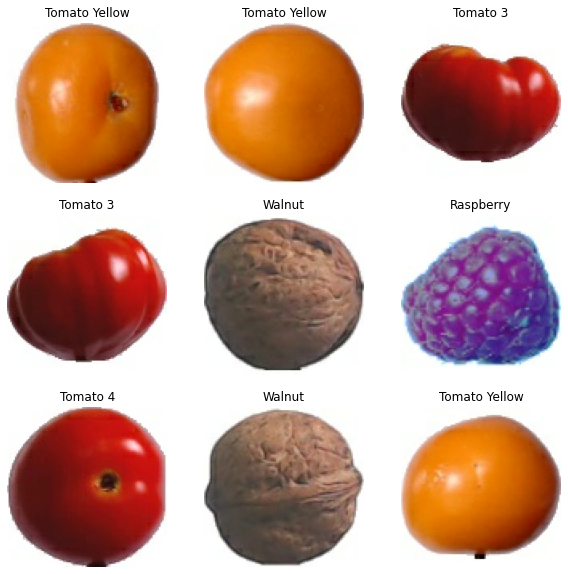

In [14]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [15]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 100, 100, 3)
(32,)


Preprocessing

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [19]:
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

94773248/94765736 [==============================] - 1s 0us/step


In [20]:
base_model.trainable = False

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

**Building the Model**

In [22]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

**Training the Model**

In [25]:
model.evaluate(val_ds)

48/48 [==============================] - 214s 3s/step - loss: 5.3499 - accuracy: 0.0000e+00


[5.349870204925537, 0.0]

In [26]:
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/10
192/192 [==============================] - 694s 45ms/step - loss: 1.8502 - accuracy: 0.4865 - val_loss: 0.6702 - val_accuracy: 0.8486
Epoch 2/10
192/192 [==============================] - 8s 44ms/step - loss: 0.5164 - accuracy: 0.8551 - val_loss: 0.2884 - val_accuracy: 0.9778
Epoch 3/10
192/192 [==============================] - 8s 44ms/step - loss: 0.2765 - accuracy: 0.9349 - val_loss: 0.1832 - val_accuracy: 0.9811
Epoch 4/10
192/192 [==============================] - 8s 44ms/step - loss: 0.1931 - accuracy: 0.9540 - val_loss: 0.1257 - val_accuracy: 0.9922
Epoch 5/10
192/192 [==============================] - 8s 44ms/step - loss: 0.1483 - accuracy: 0.9654 - val_loss: 0.0969 - val_accuracy: 0.9928
Epoch 6/10
192/192 [==============================] - 8s 44ms/step - loss: 0.1177 - accuracy: 0.9747 - val_loss: 0.0785 - val_accuracy: 0.9987
Epoch 7/10
192/192 [==============================] - 8s 44ms/step - loss: 0.0984 - accuracy: 0.9804 - val_loss: 0.0667 - val_accuracy: 0.99

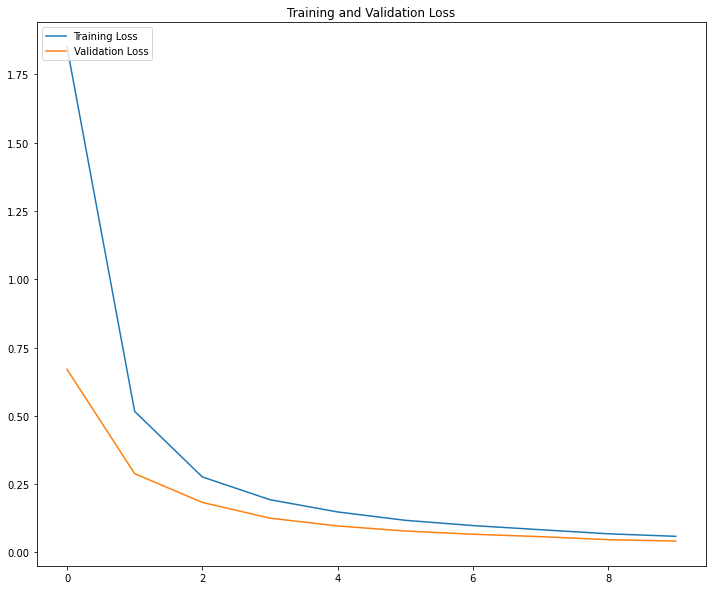

In [30]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [33]:
np.argmin(val_loss)

9